In [1]:
'''
Example of tensorflow(keras)-based siddon cone forward and backprojection
'''

'\nExample of tensorflow(keras)-based siddon cone forward and backprojection\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import tensorflow as tf
import os
import tensorflow.keras.backend as K

In [3]:
import sys
sys.path.append('..')
import projector.ct_projector_tensorflow as ct_projector_tf

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
# load a sample CT image
filename = './3.nii.gz'
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = img[np.newaxis,...]
img = img[:, ::-1, ...]
spacing = np.array(spacing[::-1])

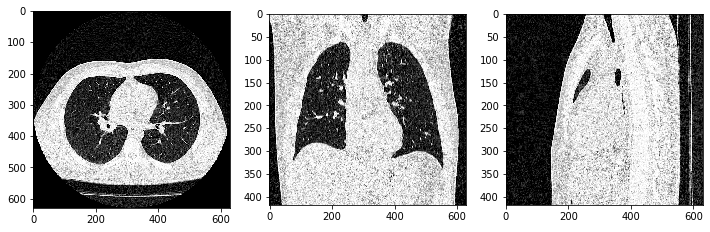

In [6]:
# show the ct images
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[0, img.shape[1]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(img[0, :, img.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(img[0, ..., img.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])

The projector holds the default parameters for the forward and backprojection. 

However, all the projection parameters are passed during calculation to enable training with various geometry. The only constraint is that within one batch the input images must be of the same shape, otherwise they cannot be passed as tensors `[batch, nx, ny, nz, channel]`. The output images must also have the same shapes. 

In [7]:
# setup the projector
projector = ct_projector_tf.ct_projector()
projector.from_file('./projector.cfg')
projector.nx = img.shape[3]
projector.ny = img.shape[2]
projector.nz = img.shape[1]
projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]

for k in vars(projector):
    print (k, '=', getattr(projector, k))

nview = 2
nu = 2048
nv = 3072
nx = 630
ny = 630
nz = 418
dx = 0.6835939884185791
dy = 0.6835939884185791
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 3000.0
dso = 2700.0
du = 0.25
dv = 0.25
off_u = 0
off_v = 0
geometry = <configparser.ConfigParser object at 0x7fa14addd690>


In [8]:
# setup the positions of projections
angles = np.array([0, 90]) * np.pi / 180

srcs = np.array([projector.dso * np.cos(angles), 
                 projector.dso * np.sin(angles), 
                 [0] * len(angles)]).T

det_centers = np.array([(projector.dso - projector.dsd) * np.cos(angles), 
                        (projector.dso - projector.dsd) * np.sin(angles), 
                        [0] * len(angles)]).T

det_us = np.array([-np.sin(angles), np.cos(angles), [0] * len(angles)]).T
det_vs = np.zeros_like(det_us)
det_vs[:, 2] = 1

In [9]:
# Make the geometry. In this example, we will generate one projection for each image in the batch. 
# The first image will take a 0-deg projection, the second image will take a 90-deg projection.
geometry = projector.make_geometry(det_centers, det_us, det_vs, srcs)

'''
The geometry is in the shape of [2, 4, 3]
2 is the batchsize, 4 is corresponding to nview = 1, 3 is the vector in 3-dimension space. 
The organization is:

geometry[0]: 
    det_center: (x0,y0,z0), (x1,y1,z1)...
    det_u: (x0,y0,z0), (x1,y1,z1)...
    det_v: (x0,y0,z0), (x1,y1,z1)...
    src: (x0,y0,z0), (x1,y1,z1)...
geometry[1]: 
    det_center: (x0,y0,z0), (x1,y1,z1)...
    det_u: (x0,y0,z0), (x1,y1,z1)...
    det_v: (x0,y0,z0), (x1,y1,z1)...
    src: (x0,y0,z0), (x1,y1,z1)...

'''
geometry = np.reshape(geometry, [4, len(angles), 3]).transpose([1, 0, 2])

In [10]:
# let's set two images in one batch. The second image is upside down.
img1 = np.copy(img)[...,np.newaxis]
img2 = np.copy(img)[...,np.newaxis]
img2 = img2[:, ::-1, ...]
imgs = np.concatenate((img1, img2), 0).transpose([0, 3, 2, 1, 4])
print (imgs.shape)

(2, 630, 630, 418, 1)


In [11]:
'''
The ground truth from eager excution. 
Note than we generated projection with size [batch, nu, nv, nview, channel]
The projection[batch=0] is corresponding to the first image with geometry at 0-deg;
The projection[batch=1] is corresponding to the second image (upside down) with geometry at 90-deg.

We multiply it by 1.5 so we can test the training function
'''
label = ct_projector_tf.SiddonConeFP(projector)(imgs, geometry = geometry).numpy() * 1.5
print (label.shape)

(2, 2048, 3072, 1, 1)


In [12]:
'''
This is the keras interface for building the model. The module can be used as any other keras modules. The gradient will be automatically calculated. 

Note that our FP module takes multiple inputs. 
The image is through the positional argument inputs, the geometry and other informations are through the keyword arguments. 
However, gradient will only flow to the image input. 
'''

K.clear_session()
img_input = tf.keras.Input(shape = [projector.nx, projector.ny, projector.nz, 1])
# geometry input. Note that this is for one image. Keras will automatically add the batch dimension.
geo_input = tf.keras.Input(shape = [4, 3])
# a very simple model: 1x1 convolution with good intialization
x = tf.keras.layers.Conv3D(1, 1, padding='same', kernel_initializer=tf.keras.initializers.Ones())(img_input)

# add our forward projection module here
fp_tensor = ct_projector_tf.SiddonConeFP(projector)(x, geometry = geo_input)

model = tf.keras.Model(inputs = [img_input, geo_input], outputs = fp_tensor)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = tf.keras.losses.mean_squared_error)

In [13]:
# train the model and observe the loss will drop
model.fit(x = [imgs, geometry], y = label, epochs = 10)

Train on 2 samples
Epoch 1/10
2/2 [==============================] - 3s 1s/sample - loss: 2.4046
Epoch 2/10
2/2 [==============================] - 1s 367ms/sample - loss: 1.6428
Epoch 3/10
2/2 [==============================] - 1s 305ms/sample - loss: 1.0922
Epoch 4/10
2/2 [==============================] - 1s 304ms/sample - loss: 0.7483
Epoch 5/10
2/2 [==============================] - 1s 261ms/sample - loss: 0.5931
Epoch 6/10
2/2 [==============================] - 1s 303ms/sample - loss: 0.5893
Epoch 7/10
2/2 [==============================] - 1s 371ms/sample - loss: 0.6794
Epoch 8/10
2/2 [==============================] - 1s 369ms/sample - loss: 0.7976
Epoch 9/10
2/2 [==============================] - 1s 579ms/sample - loss: 0.8898
Epoch 10/10
2/2 [==============================] - 1s 577ms/sample - loss: 0.9282


In [14]:
# we can verify the forward projection
fp = model.predict([imgs, geometry])

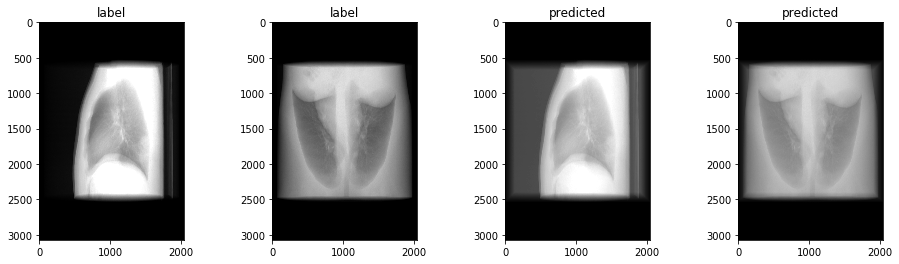

In [15]:
# show the projections
plt.figure(figsize = (len(angles)*8,4))
for i in range(len(angles)):
    plt.subplot(1,len(angles)*2,i+1); plt.title('label')
    plt.imshow(label[i, ..., 0, 0].T, 'gray', vmin=0, vmax=10)
for i in range(len(angles)):
    plt.subplot(1,len(angles)*2,i+3); plt.title('predicted')
    plt.imshow(fp[i, ..., 0, 0].T, 'gray', vmin=0, vmax=10)

## Advanced usage: set the grid, detector and output_shape for each individual image/batch

- The grid and detector can be set differently within a batch
- The output_shape can be set for each batch.

In [16]:
K.clear_session()
img_input = tf.keras.Input(shape = [projector.nx, projector.ny, projector.nz, 1])
geo_input = tf.keras.Input(shape = [4, 3])
grid_input = tf.keras.Input(shape = [6])
det_input = tf.keras.Input(shape = [4])
shape_input = tf.keras.Input(shape = [3], dtype = tf.int32)

# Let's set to use the same nu but different nv
fp_tensor = ct_projector_tf.SiddonConeFP(projector, default_shape = [-1, -1, 2048])(
    img_input, geometry = geo_input, grid = grid_input, detector = det_input, output_shape = shape_input)
print (fp_tensor)

model = tf.keras.Model(inputs = [img_input, geo_input, grid_input, det_input, shape_input], outputs = fp_tensor)

Tensor("siddon_cone_fp/Identity:0", shape=(None, 2048, None, None, 1), dtype=float32)


In [17]:
'''
grid: we used the same grid for the two images in this batch
det: we used different detector settings;
output_shape: Note that output_shape[0] need to be compatible with nview derived from geometry. We can only override nv, because nu is preset by default_shape
'''

grid = np.array([[projector.dx, projector.dy, projector.dz, projector.cx, projector.cy, projector.cz]]*2, np.float32)
det = np.array([[projector.du, projector.dv, projector.off_u, projector.off_v], 
                [projector.du * 0.75, projector.dv * 0.75, 500, 0]], np.float32)
output_shape = np.array([[1, projector.nv // 2, projector.nu // 2]]*2, np.int32)
fp = model.predict([imgs, geometry, grid, det, output_shape])

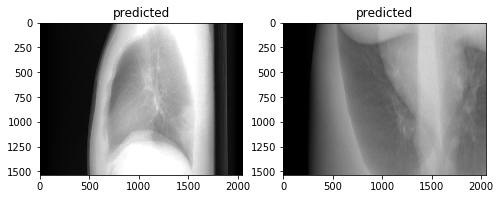

In [18]:
plt.figure(figsize = (len(angles)*4,4))
for i in range(len(angles)):
    plt.subplot(1,len(angles),i+1); plt.title('predicted')
    plt.imshow(fp[i, ..., 0, 0].T, 'gray', vmin=0, vmax=7)

In [19]:
'''
In this case we will use different number of projections (different length of geometry) for different batches

To enable this feature, we need to:
(1) set geo_input shape to [None, 3]
(2) set default_shape to [-1, ...]
'''
K.clear_session()
img_input = tf.keras.Input(shape = [projector.nx, projector.ny, projector.nz, 1])
geo_input = tf.keras.Input(shape = [None, 3])
grid_input = tf.keras.Input(shape = [6])
# we will use the same detector settings
det_input = np.array([projector.du * 0.75, projector.dv * 0.75, 250, 0], np.float32)

# Let's set to use the same nu but different nv
fp_tensor = ct_projector_tf.SiddonConeFP(projector, default_shape = [-1, 2048, 2048])(
    img_input, geometry = geo_input, grid = grid_input, detector = det_input)
print (fp_tensor)

model = tf.keras.Model(inputs = [img_input, geo_input, grid_input], outputs = fp_tensor)

Tensor("siddon_cone_fp/Identity:0", shape=(None, 2048, 2048, None, 1), dtype=float32)


In [20]:
# case 1: batch = 2, one projection for each image
grid = np.array([[projector.dx, projector.dy, projector.dz, projector.cx, projector.cy, projector.cz], 
                 [projector.dx, projector.dy, projector.dz, projector.cx, projector.cy, projector.cz + 50]], np.float32)
fp = model.predict([imgs, geometry, grid])

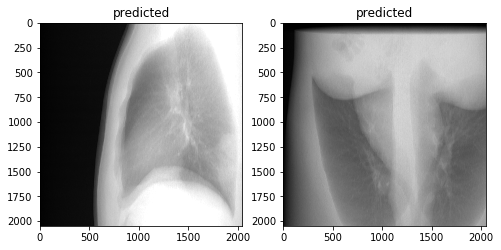

In [21]:
plt.figure(figsize = (len(angles)*4,4))
for i in range(len(angles)):
    plt.subplot(1,len(angles),i+1); plt.title('predicted')
    plt.imshow(fp[i, ..., 0, 0].T, 'gray', vmin=0, vmax=7)

In [29]:
# case 2: batch = 1, two projections for the image
grid = np.array([[projector.dx, projector.dy, projector.dz, projector.cx, projector.cy, projector.cz]], np.float32)
geo = geometry.transpose([1,0,2]).reshape([-1, 3])[np.newaxis]
fp = model.predict([imgs[[0]], geo, grid])

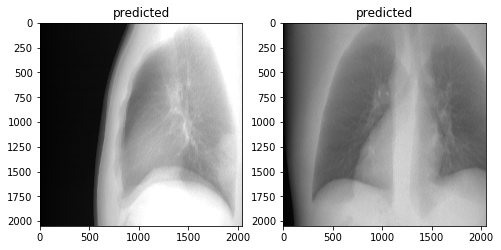

In [30]:
plt.figure(figsize = (len(angles)*4,4))
for i in range(len(angles)):
    plt.subplot(1,len(angles),i+1); plt.title('predicted')
    plt.imshow(fp[0, ..., i, 0].T, 'gray', vmin=0, vmax=7)